# This is Version 1 of our visualization tool
I use the following code to display feature lines (detected by CrestCODE based on curvature)

In [326]:
import os
import numpy as np
import open3d as o3d
import igl
import meshplot as mp
from matplotlib import pyplot as plt
from matplotlib import cm
import math

In [317]:
# extensions
PLY = ".ply"
TXT = ".txt"
# utility
NEIGHBOR = 6
MESHNAME = "tbk_crop_230328_depth=12_correctNormals_radarArchitectureONLY_smaller"
MESHFILE = "../Open3D_Test/" + MESHNAME + PLY
PSEUDO_PLY2 = "ply2" + TXT
NEWLINE = '\n'
MAX_neighbor = 10
CRESTLINE = 1 # 0 means NO Crest line, 1 means YES Crest line
# renaming CrestCode output!
RIDGES = "Ridge_" + "k=" + str(NEIGHBOR) + "_" + MESHNAME + TXT
RAVINES = "Ravine_" + "k=" + str(NEIGHBOR) + "_" + MESHNAME + TXT
OUTPUT_rename = "Output_" + "k=" + str(NEIGHBOR) + "_" + MESHNAME + TXT
PLY2_rename = "PLY2_" + "k=" + str(NEIGHBOR) + "_" + MESHNAME + TXT

In [128]:
"""Functions: for raw .ply input!"""
# input: mesh file (path)
# output1: vertices (N, 3) array; x y z coordinates
# output2: faces (F, 3) array, format: [a id, b id, c id]
def get_mesh(path):
    mesh = o3d.io.read_triangle_mesh(MESHFILE)
    print(mesh)
    verts = np.asarray(mesh.vertices)
    faces = np.asarray(mesh.triangles)
    return verts, faces
# input: output file name, neighbor (k), crestline (1 = yes, 0 = no), vertices (array), faces (array)
# does: txt file <- for CrestCODE
def to_pseudo_PLY2(name, neighbor, crestline, verts, faces):
    NEWLINE = '\n'
    verts_count = len(verts)
    faces_count = len(faces)
    with open(name, 'w') as f:
        f.write(str(verts_count) + NEWLINE)
        f.write(str(faces_count) + NEWLINE)
        f.write(str(neighbor) + NEWLINE)
        f.write(str(crestline) + NEWLINE)
        for i in range(verts_count): # all vertices x y z coordinates
            f.write(" ".join(map(str, verts[i])) + NEWLINE)
        for j in range(faces_count): # all faces a b c vertices ids
            f.write(" ".join(map(str, faces[j])) + NEWLINE)
    print(f"Success: {PSEUDO_PLY2}")

In [316]:
mesh_verts, mesh_faces = get_mesh(MESHFILE)
to_pseudo_PLY2(PSEUDO_PLY2, NEIGHBOR, CRESTLINE, mesh_verts, mesh_faces)

TriangleMesh with 3035835 points and 6064854 triangles.
Success: ply2.txt


# BOOM! You ran CrestCODE and got your .txt outputs!
<br>You ran command in the CrestCODE folder (through Terminal) and got .txt files for: output, ravines, ridges
>the input: ./setCurvature ply2.txt output.txt
><br>Note that 'ply2.txt' corresponds to (the value of) PSEUDO_PLY2

<br>The .txt show up in the CrestCODE folder
<br>You moved those files Back to Open3D_Test!

In [318]:
#cleaning up!
os.rename("ridges.txt", RIDGES)
os.rename("ravines.txt", RAVINES)
os.rename("output.txt", OUTPUT_rename)
os.rename("ply2.txt", PLY2_rename)

In [254]:
"""Functions: for CrestCODE output"""
# get data from Ridges.txt OR Ravines.txt
# input: meshfile name, mesh vertices, mesh faces
# output1: crest line vertices (V, 4) array, format: [x coordinate, y coordinate, z coordinate, connected component]
# output2: connected components (N, 3) array, format: [Ridgeness, Sphericalness, Cyclideness]
# output3: crest line edges (E, 3) array, format: [u vertex index, v vertex index, triangle ID]
def ReadCrestLine(filename):
    f = open(filename, 'r')
    V = int(f.readline())
    E = int(f.readline())
    N = int(f.readline()) # num of connected components;
    crestline_vertices = np.zeros(shape = (V, 4)) # crest line vertices
    for i in range(V): 
        line = f.readline()
        crestline_vertices[i] = [float(n) for n in line.split()]
    crestline_connected_cmp = np.zeros(shape = (N, 3)) # index = connected cmp ID
    for j in range(N):
        line = f.readline()
        crestline_connected_cmp[j] = [float(n) for n in line.split()]
    # edges (u,v): [vtx ID of u, vtx ID of v, triangle ID]
    crestline_edges = np.zeros(shape = (E, 3), dtype=int) # index = edge ID
    for k in range(E):
        line = f.readline()
        crestline_edges[k] = [n for n in line.split()]
    return V, crestline_vertices, E, crestline_edges, N, crestline_connected_cmp
# input1: crestline edges (E, 3) array, format: [u vertex index, v vertex index, triangle ID],
# input2: crestline vertices (V, 4) array, format: [x coordinate, y coordinate, z coordinate, connected component]
# output1: vertex U (E, 3) array, format: [x coordinate, y coordinate, z coordinate]
# output2: vertex V (E, 3) array, format: [x coordinate, y coordinate, z coordinate]
# edge E[i] = (U[i], V[i])
def getVertex_Pairs(crestline_edges, crestline_vertices):
    E = len(crestline_edges)
    V = len(crestline_vertices)
    U = np.zeros(shape=(E, 3))
    V = np.zeros(shape=(E, 3))
    U = np.zeros(shape = (E, 3))
    V = np.zeros(shape = (E, 3))
    for i in range(E): # use crestline_edges to find vertex index, only take first 3 numbers
        # if E[i] = a b c, this means that E[i] = (U[a], v[b])
        U[i] = crestline_vertices[crestline_edges[i][0]][0:3]
        V[i] = crestline_vertices[crestline_edges[i][1]][0:3]
    return U, V # can feed directly into meshplot :)
# input1: crestline edges (E, 3) array, format: [u vertex index, v vertex index, triangle ID],
# input2: faces frequency (F, max(k)) array, format: [face_id, frequency] <- by reference, exists outside this function
# input3: neighbor (k)
# does: add frequency values to: faces frequency array, in the column corresponding to k
def getTriangles(crestline_edges, faces_frequency, neighbor):
    # to find faces we want, we need to check edges!
    column = neighbor - 1
    E = len(crestline_edges)
    for e in range(E):
        face_id = crestline_edges[e][2]
        if(face_id != -1):
            faces_frequency[face_id][column] = 1    
# input: faces_frequency (F, max(k)) array, format: [face_id, frequency] <- by reference, exists outside this function
# output: faces_color_crestline (F, 3) array, format: [R, G, B], where each in [0, 1] float
def colorize_by_strength(faces_frequency):
    faces_frequency_total = np.sum(faces_frequency, axis=1)
    faces_color_crestline = np.ones(shape=(len(mesh_faces), 3))
    max_frequency = np.max(faces_frequency_total)
    for f in range(len(mesh_faces)):
        subtract = faces_frequency_total[f]/max_frequency
        faces_color_crestline[f][0] -= subtract
    return faces_color_crestline

## **Visualization**


In [192]:
"""run ONCE"""
faces_frequency = np.zeros(shape=(len(mesh_faces), 6))

In [ ]:
V, crestline_vertices, E, crestline_edges, N, crestline_connected_cmp = ReadCrestLine(filename=RAVINES)
U, V = getVertex_Pairs(crestline_edges=crestline_edges, crestline_vertices=crestline_vertices)
getTriangles(crestline_edges=crestline_edges, faces_frequency=faces_frequency, neighbor=NEIGHBOR)
faces_color_crestline = colorize_by_strength(faces_frequency=faces_frequency)
p = mp.plot(v=mesh_verts, f=mesh_faces, c=faces_color_crestline)
# p.add_lines(U, V, shading={"line_color": "red", "line_width": 100.0})
# p.save("TEST_Ravine_" + MESHNAME)


In [222]:
NEIGHBOR

8

In [325]:
"""Toy Mesh"""
# 2 faces
v1 = (0.0, 0.0, 0.0) # index = 0
v2 = (0.0, 0.0, 1.0) # index = 1
v3 = (0.0, 1.0, 0.0) # index = 2
v4 = (1.0, 0.0, 0.0) # index = 3
# face 1 = v1, v2, v3; face 2 = v1, v2, v4
toy_mesh_V_color = np.asarray([[1.0, 1.0, 0.1],  # <- color of face 1 
                               [0.1, 1.0, 0.1]]) # <- color of face 2
toy_mesh_V = np.asarray([v1, v2, v3, v4])
toy_mesh_F = np.asarray([[0, 1, 2], [0, 1, 3]])
# 2 feature lines, 3 endpoints
l1 = (0.0, 0.0, 0.1) # lies on edge (v1, v2)
l2 = (0.0, 0.5, 0.0) # lies on edge (v1, v3)
l3 = (0.8, 0.0, 0.0) # lies on edge (v1, v4)
toy_mesh_lines_V = np.asarray([l1, l2, l3])
toy_mesh_lines_E = np.asarray([[0, 1], [0, 2]])
# input1: crestline vertices crestline_V
# input2: crestline edges crestline_E, format: [u vertex index, v vertex index, triangle ID],
# input3: mesh faces mesh_F
# input4: mesh vertices mesh_V
# input5: mesh edges mesh_E
# output: 
# <- format: u1, u2, alpha_u, v1, v2, alpha_v
    # ith entry tells us: ith edge is made of CrestLine vertices u, v. 
    # u lies between MESH vertices u1, u2, with alpha value (from u1) of alpha_u
    # same drill for v
def LinearInterpolate_Relations(crestline_V, crestline_E, mesh_V, mesh_F):
    E = crestline_E.shape[0]
    append = np.zeros(shape=(E, 6)) 
    for e in range(E): # <- the edge is (u, v)
        crestline = crestline_E
        u = crestline_V[crestline[0]]
        v = crestline_V[crestline[1]]
        face = mesh_F[crestline[2]]
        a_idx = face[0]
        b_idx = face[1]
        c_idx = face[2]
        a = mesh_V[a_idx]
        b = mesh_V[b_idx]
        c = mesh_V[c_idx]
        u1, u2 = BetweenWhichVertices(a_idx, b_idx, c_idx, u, mesh_V)
        alpha_u = LinearInterpolate(u1, u2, u)
        v1, v2 = BetweenWhichVertices(a_idx, b_idx, c_idx, v, mesh_V)
        alpha_v = LinearInterpolate(v1, v2, v)
        append[e] = np.asarray([u1, u2, alpha_u, v1, v2, alpha_v])
    return append

def BetweenWhichVertices(a_idx, b_idx, c_idx, v, mesh_V):
    a = mesh_V[a_idx]
    b = mesh_V[b_idx]
    c = mesh_V[c_idx]
    va = a - v
    vb = b - v
    vc = c - v
    cp_ab = np.cross(a=va, b=vb)
    if(cp_ab == 0): return a_idx, b_idx
    cp_bc = np.cross(a=vb, b=vc)
    if(cp_bc == 0): return b_idx, c_idx
    cp_ac = np.cross(a=va, b=vc)
    if(cp_ac == 0): return a_idx, c_idx

def LinearInterpolate(a, b, v):
    va = a - v
    ab = b - a
    va_length = math.sqrt(np.sum(element ** 2 for element in va))
    ab_length = math.sqrt(np.sum(element ** 2 for element in ab))
    alpha = va_length / ab_length
    return alpha

def Recover
toy = mp.plot(v=toy_mesh_V, f=toy_mesh_F, c=toy_mesh_V_color)
toy.add_edges(vertices=toy_mesh_lines_V, edges=toy_mesh_lines_E)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5, 0.5,…

1

In [ ]:
"""Linear Interpolation"""


In [319]:
# input1: maximum neighbor (k)
# input2: mesh_faces (F, 3) array
# output: faces_frequency (F, max(k)) array, 
#   format: faces_frequency[i][j] = 1 means ith face contains crestlines for neighbor = j; 0 otherwise
def read_ravine_multiple(max_neighbor, mesh_faces):
    faces_freq = np.zeros(shape=(len(mesh_faces), max_neighbor))
    for n in range(1, NEIGHBOR + 1):
        filename = RAVINES = "Ravine_" + "k=" + str(n) + "_" + MESHNAME + TXT
        print(f"reading {filename}")
        V, crestline_vertices, E, crestline_edges, N, crestline_connected_cmp = ReadCrestLine(filename=RAVINES)
        getTriangles(crestline_edges=crestline_edges, faces_frequency=faces_freq, neighbor=n)
    return faces_freq
# input: faces_frequency (F, max(k)) array
# output: faces_colorful_crestline (F, 3) array, format: [R, G, B], where each in [0, 1] float
#   [small, 1, 1] = turquoise
#   [1, small, 1] = purple
#   [1, 1, small] = yellow
#   [1, small, small] = red
#   [small, small, 1] = blue
#   [small, 1, small] = green
colors = {
    '1': np.array([1.0, 0.1, 1.0]), # purple
    '2': np.array([0.1, 1.0, 0.1]), # turquoise
    '3': np.array([0.1, 0.1, 1.0]), # blue
    '4': np.array([0.1, 1.0, 0.1]), # green
    '5': np.array([1.0, 1.0, 0.1]), # yellow
    '6': np.array([1.0, 0.1, 0.1]), # red
    'threshold': np.array([0, 0, 0]) # black
    }
def colorful_by_strength(freq):
    tally = np.sum(freq, axis=1)
    faces_color = np.ones(shape=(len(freq), 3))
    for f in range(len(freq)):
        if(tally[f] == 6):
            faces_color[f] = colors['6']
        elif(tally[f] == 5):
            faces_color[f] = colors['5']
        elif(tally[f] == 4):
            faces_color[f] = colors['4']
        elif(tally[f] == 3):
            faces_color[f] = colors['3']
        elif(tally[f] == 2):
            faces_color[f] = colors['2']
        elif(tally[f] == 1):
            faces_color[f] = colors['1']
        else:
            faces_color[f] = np.ones(3)
    return faces_color
# input1: faces_frequency (F, max(k)) array
# input2: threshold
# output: strongest_color (F, 3) array, format: [R, G, B], where each in [0, 1] float
#   ONLY keep color of 
def colorful_by_strongest(freq_, threshold):
    tally = np.sum(freq_, axis=1)
    faces_color = np.ones(shape=(len(freq_), 3))
    for f in range(len(freq_)):
        if(tally[f] >= threshold):
            faces_color[f] = colors['threshold']
        else:
            faces_color[f] = np.ones(3)
    return faces_color
# input: generic array
# output: length of longest subarray, where entries are != 0 throughout
def longest_continuous(array):
    count = 0
    best = 0
    for n in array:
        if(n == 0):
            count = 0
        else:
            count += 1
            best = max(count, best)
    return best
# input1: faces_frequency (F, max(k)) array
# input2: threshold
# output: strongest_color (F, 3) array, format: [R, G, B], where each in [0, 1] float
#   ONLY keep color of 
def colorful_by_strongest_continuous(freq_, threshold):
    faces_color = np.ones(shape=(len(freq_), 3))
    for f in range(len(freq_)):
        longest = longest_continuous(freq_[f])
        if(longest >= threshold):
            faces_color[f] = colors['threshold']
        else:
            faces_color[f] = np.ones(3)
    return faces_color
# getJetColor()
# input: frequency_value in [1, MAX_neighbor]
#   frequency_value = 0 is given white color RGB = [1, 1, 1]
# output: ndarray (3,) of RGB = [R, G, B]
def getJetColor(frequency_value):
    jet = cm.get_cmap('jet') # extract 'jet' colormap from matplotlib; type: matplotlib.colors.LinearSegmentedColormap
    jet_custom = jet(np.linspace(0, 1, MAX_neighbor)) # get evenly-spaced colors, type: ndarray
    # if frequency is 0, 
    frequency_index = frequency_value - 1
    return jet_custom[frequency_index][0:3]
# colorful_by_strongest_continuous_jet
# input1: faces_frequency (F, max(k)) array
# input2: threshold
# output: strongest JET color (F, 3) array, format: [R, G, B], where each in [0, 1] float
#   ONLY keep color of 
def colorful_by_strongest_continuous_jet(freq_):
    faces_color = np.ones(shape=(len(freq_), 3))
    for f in range(len(freq_)):
        longest = longest_continuous(freq_[f])
        if(longest > 0):
            faces_color[f] = getJetColor(longest)
        else:
            faces_color[f] = np.ones(3) # frequency = 0 -> white color!
    return faces_color


freqency = read_ravine_multiple(max_neighbor=MAX_neighbor, mesh_faces=mesh_faces)
# colorful = colorful_by_strength(freq=freq)
color_threshold_continuous_jet = colorful_by_strongest_continuous_jet(freq_=freqency)
color_threshold_continuous = colorful_by_strongest_continuous(freq_=freqency, threshold=5)
color_threshold = colorful_by_strongest(freq_=freqency, threshold=6)
q = mp.plot(v=mesh_verts, f=mesh_faces, c=color_threshold_continuous_jet)

reading Ravine_k=1_tbk_crop_230328_depth=12_correctNormals_radarArchitectureONLY_smaller.txt


FileNotFoundError: [Errno 2] No such file or directory: 'Ravine_k=1_tbk_crop_230328_depth=12_correctNormals_radarArchitectureONLY_smaller.txt'

In [312]:
q.save(filename="k[1,9]_frequency>=5_not_persistence")

Plot saved to file k[1,9]_frequency>=5_not_persistence.html.


# **230424**
I start by cropping the original TBK mesh in Meshlab. I crop conservatively, only keeping parts of the mesh that have visible archaeological features.
<br>Before cropping, the mesh has 6.3 million vertices and 12.7 million faces
<br>After cropping, the mesh has 3 million vertices and 6 million faces

>This takes more than 10 minutes to run! So I make an even smaller crop

<br>I make an even smaller mesh with 2.1 million vertices and 4.2 million faces

>start time: 10:25am


In [304]:
# input: frequency_value in [1, MAX_neighbor]
#   frequency_value = 0 is given white color RGB = [1, 1, 1]
# output: ndarray (3,) of RGB = [R, G, B]
def getJetColor(frequency_value):
    jet = cm.get_cmap('jet') # extract 'jet' colormap from matplotlib; type: matplotlib.colors.LinearSegmentedColormap
    jet_custom = jet(np.linspace(0, 1, MAX_neighbor)) # get evenly-spaced colors, type: ndarray
    # if frequency is 0, 
    frequency_index = frequency_value - 1
    return jet_custom[frequency_index][0:3]
getJetColor(10)


array([0.5, 0. , 0. ])

jet.colors (12, 4)
viridis.colors (12, 4)


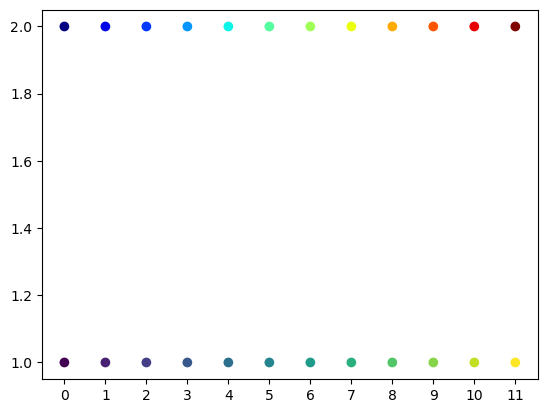

[0.33839342 1.         0.62934851 1.        ]


In [292]:
jet = cm.get_cmap('jet')
jet_12_colors = jet(np.linspace(0, 1, 12))
print('jet.colors', jet_12_colors.shape)

viridis = cm.get_cmap('viridis', 12)
print('viridis.colors', viridis.colors.shape)

plt.scatter(range(12), np.repeat(2, 12), color=jet_12_colors)
plt.scatter(range(12), np.repeat(1, 12), color=viridis.colors)
plt.xticks(range(12))
plt.show()
print(jet_12_colors[5])

In [293]:
V = np.array([
    [0., 0, 0],
    [1, 0, 0],
    [1, 1, 1],
    [2, 1, 0]
])

F = np.array([
    [0, 1, 2],
    [1, 3, 2]
])

color = np.array([
    [1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0]
])

color1 = np.array([
    0.33839342, 1.0, 0.62934851
])

mp.plot(V, F, c=color1)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.0, 0.5,…

In [249]:
test = np.array([
    [1,1],
    [2,2]
])

test[0]

array([1, 1])

In [188]:
q.save(filename="frequency_colorful_threshold=5")

Plot saved to file frequency_colorful_threshold=5.html.


In [200]:
"""#Example# get: faces; from: face index"""
F = np.asarray([0,1,2])
G = np.zeros(shape=(1,4))
G[:,0:3] = F
print(G)
# got: 
# [edge_u_index, edge_v_index, face_index] <- edges
# [a_index, b_index, c_index] @ face_index
# [x, y, z] @ a_index
# want:
# select faces by index
# tally appearance count for ea face

[[0. 1. 2. 0.]]


In [198]:
"""#Example# get: vertices; from: vertex index"""
A = np.asarray([[0, 1, 2]]) # edges, form: (u index, v index)
B = np.asarray([[5,6,0],[7,8,0],[9,10,0]]) # verts, form: (x, y, z)
# want: C = [5,6], D = [7,8] <- selected verts by indices; indices from edges
C = np.zeros(shape=(A.shape[0],2))
D = np.zeros(shape=(A.shape[0],2))
for i in range(len(A)):
    C[i] = B[A[i][0]][0:2]
    D[i] = B[A[i][1]][0:2]
print(B[1][0:2])
print(C)
print(D)

[7 8]
[[5. 6.]]
[[7. 8.]]


In [138]:
(V, N, E, CL_vertices, connected_cmp, edges) = RawData(RAVINES)
selected_faces = np.zeros((faces.shape[0],4))
selected_faces[:,0:3] = faces
selected_faces[1]



array([14., 13.,  3.,  0.])

In [135]:
triangle_indices = edges[:,2]
for i in range(len(triangle_indices)):
    if(i != -1):
        selected_faces[3] += 1
print(selected_faces[55498])

[28474. 28472. 24778.     0.]


In [ ]:
# show ravines (very nice)
ravines(RAVINES, verts, faces)

In [ ]:
# show entire mesh (no nothing)
p = mp.plot(verts, faces, return_plot=True)

In [52]:
# Save
p.save("FeatureLines_" + MESHNAME + "_neighbor=" + str(NEIGHBOR))

Plot saved to file FeatureLines_tbk_crop_230328_depth=12_correctNormals_crop_2_neighbor=6.html.


In [103]:
# Reference: 
# http://www.open3d.org/docs/0.11.1/tutorial/visualization/visualization.html
(V, N, E, vertices, connected_cmp, edges) = RawData(RAVINES)
points = vertices[:,:3]
lines = edges[:,:2]
colors = [[1, 0, 0] for i in range(E)]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(lines),
)
line_set.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_line_set(RAVINES + PLY, line_set, print_progress=True)
#test

Writing PLY: [========================================] 100%


True

In [ ]:
# all feature lines
show(RIDGES, RAVINES, verts, faces)
# just show ridges (not very useful)
ridges(RIDGES, verts, faces)